# Wedgex

Use an analytical solution to particle trajectories in an orogenic wedge, use the particle depths to calculate thermochronometer cooling ages and compare to thermochronology data.

The default parameters and data are based on a cross-section in the Himalayas as published by McQuarrie and Ehlers (2015) Tectonics, https://doi.org/10.1002/2014TC003783

The model parameters, such as compression and accretion velocities can be specified below in the Model Parameters box 

## Import modules

In [1]:
import string
import itertools
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

import sklearn.metrics

import scipy.optimize

# equations for particle trajectories
import wedgeqs

## Filenames

In [2]:
# name of file with thermochron data
thermochron_data_file = 'data/thermochron_data_projected.csv'

# column with distance
distance_column = 'projected_distance_along_xsection'
thermochronometer_col = 'system'

# filename for output file with modelled ages thermochron samples
thermochron_output_file = 'data/modelled_thermochron_data.csv'

# output file with modelled ages vs distance
thermochron_profile_file = 'data/modelled_thermochron_profiles.csv'

## Model parameters

In [3]:
# avg. convergence McQuarrie & Ehlers(2015) = 18 mm/yr

#  best-fit params
# -0.00404647 -0.00844319  0.00026324

# compressional velocity
#vc = -18e-3
#vc = -7e-3
vc = -0.00404647

# transport velocity
vd = 0.0

# accretion velcotiy
#vxa = 0.0
vxa = -0.00844319

#vya = 0.0
vya = 0.00026324

# lenght of wedge
L = 200e3

# slope of topography (m/m)
# for McQuarrie & Ehlers: ~ 4km over 117 km 
alpha = 0.034

# slope of bottom of wedge (m/m)
# for McQuarrie & Ehlers: detachment depth at N edge xsection (117 km) = ~20 km
beta = -0.17

# disctance between surface points (m)
x_interval = 5e3

x_first_pt = 1e3

# number of rows in the orogenic wedge. Used for figures only, no function in the actual model
n_rows = 100

# modelled timespan (years)
max_time = 1e8

# timestep size (years)
dt = 1e4

# names of thermochronometers, should match the names in your input file
thermochron_systems = ['AHe', 'AFT', 'ZHe', 'ZFT', 'MAr']

# resetting temperatures
resetting_temperatures = [70.0, 110.0, 180.0, 230.0, 325.0]

# geothermal gradient, used to convert resetting temp to depth (degr. C/m)
# 10-20 C per km (Coutand et al. 2014)
geothermal_gradient = 0.015 

# surface temperature at sea lvl (degr. C)
surface_temperature_sea_lvl = 24.0

# adiabatic lapse rate (C/m), used to correct surface temperature for elevation
lapse_rate = 7 / 1e3



## Options for figures

In [4]:
# some figure options
fig_output_file = 'fig/model_output_figure.pdf'
thermochron_markers = ['o', 'd', 's', '^', 'h']
thermochron_colors = ['darkblue', 'blue', 'green', 'red', 'orange']

# maximum thermochron age on y-axis
max_age_fig = 20.0

fs = 'small'

## Set up initial particle positions and timesteps

In [5]:
# x-coordinates of starting points:
x0s = np.arange(0, L + x_interval, x_interval)
x0s[0] = x_first_pt

# timesteps (years)
t = np.arange(0, -max_time - dt, -dt)

print('particle starting points (m from tip of wedge):\n', x0s)

print('timesteps (yr):\n', t / 1e6)

particle starting points (m from tip of wedge):
 [  1000.   5000.  10000.  15000.  20000.  25000.  30000.  35000.  40000.
  45000.  50000.  55000.  60000.  65000.  70000.  75000.  80000.  85000.
  90000.  95000. 100000. 105000. 110000. 115000. 120000. 125000. 130000.
 135000. 140000. 145000. 150000. 155000. 160000. 165000. 170000. 175000.
 180000. 185000. 190000. 195000. 200000.]
timesteps (yr):
 [ 0.000e+00 -1.000e-02 -2.000e-02 ... -9.998e+01 -9.999e+01 -1.000e+02]


## Load thermochron data

In [6]:
df = pd.read_csv(thermochron_data_file)

print('thermochron data systems in file: ', df[thermochronometer_col].unique())

thermochron data systems in file:  ['ZHe' 'AFT' 'MAr']


## Remove anomalously old ages

In [7]:
print(df['age'].describe())
df = df[df['age'] < 100.0]
print(df['age'].describe())

count      37.000000
mean       72.310000
std       278.836678
min         2.700000
25%         4.790000
50%         8.400000
75%         9.680000
max      1395.700000
Name: age, dtype: float64
count    35.00000
mean      7.39600
std       3.01538
min       2.70000
25%       4.65500
50%       7.50000
75%       9.40000
max      14.78000
Name: age, dtype: float64


## Set up geometry of wedge

In [8]:
xcoords = np.linspace(0, L, 101)
y_top = xcoords * alpha
y_bottom = xcoords * beta

H = y_top.max() - y_bottom.min()

print('with the chosen slopes of land surface and wedge bottom/detachment the max height of '
      'the wedge is : ', H / 1e3, ' km')

ys = np.zeros((len(xcoords), n_rows))
xs = np.zeros_like(ys)
ybs = np.zeros_like(ys)

for i in range(len(xcoords)):
    ys[i, :] = np.linspace(y_bottom[i], y_top[i], n_rows)
    xs[i, :] = xcoords[i]
    ybs[i, :] = y_bottom[i]

with the chosen slopes of land surface and wedge bottom/detachment the max height of the wedge is :  40.8  km


## Run model for regular spacing of surface samples for figure

In [9]:
# analytical solution for particle trajectories
xyp = np.array([wedgeqs.analytical_solution(t, x0, alpha, beta, L, vc, vd, vxa, vya) for x0 in x0s])

# get x and y coordinates particles
xp, yp = xyp[:, 0], xyp[:, 1]

# calculate depth of the particles
yp0 = xp * alpha
dp = yp0 - yp

## Calculate cooling ages for age vs distance curves

In [10]:
#target_depths = [2000.0, 4000.0]
# surface elevation
y0s = x0s * alpha

# surface temperature
sT = surface_temperature_sea_lvl - lapse_rate * y0s

modelled_ages_th = np.zeros((len(thermochron_systems), x0s.shape[0]))

for i, thc, rt in zip(itertools.count(), thermochron_systems, resetting_temperatures):
    rds =  (rt - sT) / geothermal_gradient

    for j, rd in enumerate(rds):
        age_int = np.interp(rd, dp[j], t)
        modelled_ages_th[i, j] = age_int

## Calculate resetting depth for sample positions

In [11]:
df['resetting_temp'] = np.nan

for thc, rt in zip(thermochron_systems, resetting_temperatures):
    
    ix = df[thermochronometer_col] == thc 
    df.loc[ix, 'resetting_temp'] = rt

# calculate surface temperature
df['surface_T'] = surface_temperature_sea_lvl - lapse_rate * df['elevation']
df['resetting_depth'] = (df['resetting_temp'] - df['surface_T']) / geothermal_gradient

#df.head()

## Run model at exact location of surface samples

In [12]:
# get sample positions from dataframe
x0_samples = df[distance_column]

# use analytical solution to calculate particle trajectories
xy_samples = np.array([wedgeqs.analytical_solution(t, x0, alpha, beta, L, vc, vd, vxa, vya) 
                       for x0 in x0_samples])

# get x and y coordinates
x_samples, y_samples = xy_samples[:, 0], xy_samples[:, 1]

# calculate depths
y0_samples = x_samples * alpha
d_samples = y0_samples - y_samples

## Calculate modelled ages for samples

In [13]:
target_temp_samples = df['resetting_temp'].values

n_samples = len(df)

modelled_age_samples = np.zeros((n_samples))

for j, tt, y0s, xs, ds in zip(list(range(n_samples)), target_temp_samples, 
                              y0_samples, x_samples, d_samples):
    
    surface_Ts = surface_temperature_sea_lvl + y0s * lapse_rate
    
    T_sample = surface_Ts + ds * geothermal_gradient
    
    age_int = np.interp(tt, T_sample, t)
    modelled_age_samples[j] = age_int

df['modelled_age'] = -modelled_age_samples / 1e6

## Compare modelled and measured depth vs t data

In [14]:
ind_ok = df[['age', 'modelled_age']].notnull().all(axis=1)

R2 = sklearn.metrics.r2_score(df.loc[ind_ok, 'age'], df.loc[ind_ok, 'modelled_age'])
MAE = sklearn.metrics.mean_absolute_error(df.loc[ind_ok, 'age'], df.loc[ind_ok, 'modelled_age'])

df.loc[ind_ok, 'R2 for all samples combined'] = R2
df.loc[ind_ok, 'MAE for all samples combined'] = MAE

print('MAE value modelled and measured ages = ', MAE)
print('R2 value modelled and measured ages = ', R2)


MAE value modelled and measured ages =  3.6863161925358106
R2 value modelled and measured ages =  -26.38567188939421


## Make a figure of the results

saving figure as fig/model_output_figure.pdf


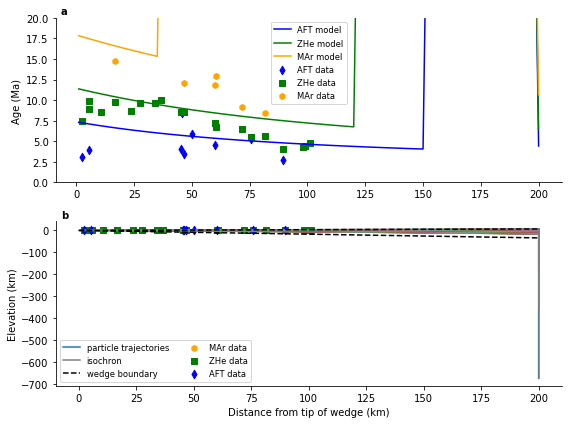

In [15]:
target_ts = [5e6, 10e6, 50e6, 100e6]

xpi, ypi = xp, yp
dpi = dp

fig, axs = pl.subplots(2, 1, figsize=(8, 6))

############################
# panel with time at depth=x
############################
for i, thc, c in zip(itertools.count(), thermochron_systems,  thermochron_colors):
    if thc in df[thermochronometer_col].values:
        axs[0].plot(x0s / 1e3, -modelled_ages_th[i] / 1e6, label='%s model' % thc, color=c)

    
for thc, m, c in zip(thermochron_systems, thermochron_markers, thermochron_colors):
    
    ix = df[thermochronometer_col] == thc
    
    if np.any(ix) == True:
        axs[0].scatter(df.loc[ix, distance_column] / 1e3, df.loc[ix, 'age'], label='%s data' % thc, color=c, marker=m)

axs[0].set_ylim(0, max_age_fig)
        
axs[0].set_ylabel('Age (Ma)')

axs[0].legend(fontsize=fs)

#######################
# particle trajectories
#######################

ax = axs[-1]

ind = xpi > L
xpi[ind] = np.nan
ypi[ind] = np.nan

for xl, yl in zip(xpi, ypi):
    leg_traj, = ax.plot(xl / 1e3, yl / 1e3)

nt = xpi.shape[1]

isochron_ts = np.linspace(0, nt - 1, 5).astype(int)

for nti in isochron_ts:
    #leg_ts =  ax.scatter(xpi[:, nti] / 1e3, ypi[:, nti] / 1e3, s=20, color='black')
    leg_tsl, =  ax.plot(xpi[:, nti] / 1e3, ypi[:, nti] / 1e3, color='gray', ls='-')
    pass

legs_tc = []
labels_tc = []

for thc, m, c in zip(thermochron_systems[::-1], thermochron_markers[::-1], thermochron_colors[::-1]):
    
    ix = df[thermochronometer_col] == thc
        
    if np.any(ix) == True:
        labels_tc.append('%s data' % thc)
        li = ax.scatter(df.loc[ix, distance_column] / 1e3, df.loc[ix, 'elevation'] / 1e3, color=c, marker=m)
        legs_tc.append(li)
        
#leg_s = ax.scatter(df['distance'], df['elevation'] / 1e3, label='thermochron samples')

leg_bnd, = ax.plot(xcoords / 1e3, y_top / 1e3, color='black', ls='--', lw=1.5)
ax.plot(xcoords / 1e3, y_bottom / 1e3, color='black', ls='--', lw=1.5)

ax.set_xlabel('Distance from tip of wedge (km)')
ax.set_ylabel('Elevation (km)')

#ax.set_aspect('equal')

for i, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.01, 1.01, string.ascii_lowercase[i], 
            weight='bold', transform=ax.transAxes, 
               ha='left', va='bottom', fontsize='medium')

legs = [leg_traj, leg_tsl, leg_bnd] + legs_tc
labels = ['particle trajectories', 'isochron', 'wedge boundary'] + labels_tc
axs[-1].legend(legs, labels, loc='lower left', ncol=2, fontsize=fs)

fig.tight_layout()

print('saving figure as %s' % fig_output_file)
fig.savefig(fig_output_file)


## Save the file with the modelled ages

In [16]:
df['L'] = L
df['alpha'] = alpha
df['beta'] = beta
df['vd'] = vd
df['vc'] = vc
df['geothermal_gradient'] = geothermal_gradient

print('saving modelled ages thermochron samples to %s' % thermochron_output_file)
df.to_csv(thermochron_output_file)

saving modelled ages thermochron samples to data/modelled_thermochron_data.csv


## Save modelled themrochron distance vs age profiles

In [17]:
cols = thermochron_systems
index = x0s

dp = pd.DataFrame(index=index, columns=cols)

for i, col in enumerate(cols):
    dp[col] = - modelled_ages_th[i] / 1e6
    
dp['L'] = L
dp['alpha'] = alpha
dp['beta'] = beta
dp['vd'] = vd
dp['vc'] = vc
dp['geothermal_gradient'] = geothermal_gradient

print('saving modelled thermochron profiles as %s' % thermochron_profile_file)
dp.to_csv(thermochron_profile_file, index_label='distance')

saving modelled thermochron profiles as data/modelled_thermochron_profiles.csv
